# This notebook is based in the book: 
# Deep Learning with Keras
## Implement neural networks with Keras on Theano and TensorFlow

### Authors:  Antonio Gulli, Sujit Pal

- Code: https://github.com/PacktPublishing/Deep-Learning-with-Keras

### The first example of Keras code
The initial building block of Keras is a model, and the simplest model is called sequential. A sequential Keras model is a linear pipeline (a stack) of neural networks layers. This code fragment defines a single layer with **12 artificial neurons**, and it expects **8 input variables (also known as features)**.In this example **random_uniform** is used to initialize the weiths of the layers with uniformly random small values.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
#random_uniform Weights are initialized to uniformly random small values in (-0.05, 0.05).
#There are more ways to initialize weights: https://keras.io/initializers/
model.add(Dense(12, input_dim=8, kernel_initializer='random_uniform')) 


**Note:** The _net is dense_, meaning that each neuron in a layer is connected to all neurons
located in the previous layer and to all the neurons in the following layer.

**Sigmoid Function:** $\sigma(x)= \frac{1}{1+e^{-x}}$ -> used by neuron for computing the nonlinear function $\sigma(z=wx+b)
$. A neuron with sigmoid activation has a behavior similar to the perceptron, but the changes are gradual.

**Sigmoid** and **ReLU** are generally called **activation functions** in neural network jargon. They are the basic building blocks to developing a learning algorithm which adapts little by little, by progressively reducing the mistakes made by our nets.

Full list of activation function is available at https://keras.io/activations/.

**One-hot enconding- OHE**

In many applications, it is convenient to transform categorical (non-numerical) features into numerical
variables. For instance, the categorical feature digit with the value d in [0-9] can be encoded into a
binary vector with 10 positions, which always has 0 value, except the d-th position where a 1 is
present.

## A real example — recognizing handwritten digits

In this section, we will build a network that can recognize handwritten numbers. For achieving this
goal, we use MNIST (for more information, refer to http://yann.lecun.com/exdb/mnist/), a database of
handwritten digits made up of a training set of 60,000 examples and a test set of 10,000 examples.
The training examples are annotated by humans with the correct answer. For instance, if the
handwritten digit is the number three, then three is simply the label associated with that example.

In [22]:
from __future__ import print_function
import numpy as np
from keras.datasets import mnist                       #import dataset
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
np.random.seed(1671)                                   # for reproducibility

In [8]:
# network and training
NB_EPOCH = 200
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10                        # number of outputs = number of digits
OPTIMIZER = SGD()                      # SGD optimizer, explained later in this chapter
N_HIDDEN = 128
VALIDATION_SPLIT=0.2                   # how much TRAIN is reserved for VALIDATION: 
                                       # 60000*0.8 ->Training 60000*0.2->Validation
                                       # Testing after Training: 10000

We need terminologies like **epochs, batch size, iterations** only when the data is too big which happens all the time in machine learning and we can’t pass all the data to the computer at once. So, to overcome this problem we need to divide the data into smaller sizes and give it to our computer one by one and update the weights of the neural networks at the end of every step to fit it to the data given.

**Epochs**: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.

As the number of **epochs increases**, more number of times the weight are changed in the neural network and the curve goes from underfitting to optimal to overfitting curve.

**Batch Size**: Total number of training examples present in a single batch. As I said, you can’t pass the entire dataset into the neural net at once. So, you divide dataset into Number of Batches or sets or parts. Just like you divide a big article into multiple sets/batches/parts like Introduction, Gradient descent, Epoch, Batch size and Iterations which makes it easy to read the entire article for the reader and understand it.

**Iterations**: It is the number of batches needed to complete one epoch. Let’s say we have 2000 training examples that we are going to use. We can divide the dataset of 2000 examples into batches of 500 then it will take 4 iterations to complete 1 epoch.

In [9]:
# data: shuffled and split between train and test sets

(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

11493376/11490434 [==============================] - 11s 1us/step
60000 train samples
10000 test samples


The **input layer has a neuron associated with each pixel in the image for a total of 28 x 28 = 784
neurons**, one for each pixel in the MNIST images.
Typically, the values associated with each pixel are normalized in the range [0, 1] (which means that
the intensity of each pixel is divided by 255, the maximum intensity value). The output is 10 classes,
one for each digit.
The **final layer** is a single neuron with **activation function softmax**, which is a generalization of the
sigmoid function. **Softmax squashes** a k-dimensional vector of arbitrary real values into a k-dimensional
vector of real values in the range (0, 1). In our case, it aggregates 10 answers provided by the previous layer with **10 neurons:**

In [10]:
# 10 outputs
# final stage is softmax
model = Sequential()
model.add(Dense(NB_CLASSES, input_shape=(RESHAPED,)))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


**Compilation**

Once we define the model, we have to compile it so that it can be executed by the Keras backend
(either Theano or TensorFlow). There are a few choices to be made during compilation:
- We need to **select the optimizer** that is the specific algorithm used **to update weights** while we train our model
- We need to **select the objective function** that is used by the optimizer to navigate the space of weights (frequently, objective functions are called **loss function**, and the process of optimization is defined as a **process of loss minimization**) -> https://keras.io/losses/ -> MSE, Binary Cross-entropy, Categorical Cross-entropy, Accuracy, Precision, Recall)
- We need to evaluate the trained model.

In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer=OPTIMIZER, 
              metrics=['accuracy'])

Metrics are similar to objective functions, with the only difference that they are not used for training a
model but only for evaluating a model.

Once the model is compiled, it can be then **trained** with the **fit() function**, which specifies a few
parameters:
- **epochs:** This is the number of times the model is exposed to the training set. At each iteration, the optimizer tries to adjust the weights so that the objective function is minimized.
- **batch_size:** This is the number of training instances observed before the optimizer performs a weight update.

In [12]:
#Training the model
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 1s 16us/step - loss: 1.3633 - acc: 0.6796 - val_loss: 0.8904 - val_acc: 0.8246
Epoch 2/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.7913 - acc: 0.8272 - val_loss: 0.6572 - val_acc: 0.8546
Epoch 3/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.6436 - acc: 0.8497 - val_loss: 0.5625 - val_acc: 0.8681
Epoch 4/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.5717 - acc: 0.8602 - val_loss: 0.5098 - val_acc: 0.8765
Epoch 5/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.5276 - acc: 0.8678 - val_loss: 0.4758 - val_acc: 0.8826
Epoch 6/200
48000/48000 [==============================] - 1s 13us/step - loss: 0.4973 - acc: 0.8726 - val_loss: 0.4515 - val_acc: 0.8866
Epoch 7/200
48000/48000 [==============================] - 1s 15us/step - loss: 0.4748 - acc: 0.8775 - val_loss: 0.4333 - 

48000/48000 [==============================] - 1s 11us/step - loss: 0.3143 - acc: 0.9128 - val_loss: 0.3022 - val_acc: 0.9151
Epoch 60/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.3136 - acc: 0.9129 - val_loss: 0.3016 - val_acc: 0.9161
Epoch 61/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.3130 - acc: 0.9133 - val_loss: 0.3011 - val_acc: 0.9158
Epoch 62/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.3123 - acc: 0.9131 - val_loss: 0.3007 - val_acc: 0.9151
Epoch 63/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.3117 - acc: 0.9136 - val_loss: 0.3003 - val_acc: 0.9156
Epoch 64/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.3110 - acc: 0.9137 - val_loss: 0.2997 - val_acc: 0.9158
Epoch 65/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.3105 - acc: 0.9137 - val_loss: 0.2992 - val_acc: 0.9159
Epoch 66/200
48000/48000 [==============

Epoch 118/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2902 - acc: 0.9192 - val_loss: 0.2846 - val_acc: 0.9212
Epoch 119/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2900 - acc: 0.9191 - val_loss: 0.2844 - val_acc: 0.9212
Epoch 120/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2898 - acc: 0.9192 - val_loss: 0.2842 - val_acc: 0.9212
Epoch 121/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2895 - acc: 0.9191 - val_loss: 0.2841 - val_acc: 0.9212
Epoch 122/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2892 - acc: 0.9192 - val_loss: 0.2840 - val_acc: 0.9212
Epoch 123/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2890 - acc: 0.9194 - val_loss: 0.2838 - val_acc: 0.9211
Epoch 124/200
48000/48000 [==============================] - 0s 10us/step - loss: 0.2888 - acc: 0.9197 - val_loss: 0.2837 - val_acc: 0.9210
Epoch 125/200
48000/

48000/48000 [==============================] - 1s 12us/step - loss: 0.2793 - acc: 0.9220 - val_loss: 0.2775 - val_acc: 0.9232
Epoch 177/200
48000/48000 [==============================] - 1s 12us/step - loss: 0.2791 - acc: 0.9219 - val_loss: 0.2774 - val_acc: 0.9234
Epoch 178/200
48000/48000 [==============================] - 1s 12us/step - loss: 0.2790 - acc: 0.9221 - val_loss: 0.2774 - val_acc: 0.9228
Epoch 179/200
48000/48000 [==============================] - 1s 12us/step - loss: 0.2788 - acc: 0.9221 - val_loss: 0.2773 - val_acc: 0.9232
Epoch 180/200
48000/48000 [==============================] - 1s 12us/step - loss: 0.2787 - acc: 0.9221 - val_loss: 0.2771 - val_acc: 0.9235
Epoch 181/200
48000/48000 [==============================] - 1s 12us/step - loss: 0.2785 - acc: 0.9223 - val_loss: 0.2770 - val_acc: 0.9232
Epoch 182/200
48000/48000 [==============================] - 1s 11us/step - loss: 0.2784 - acc: 0.9220 - val_loss: 0.2769 - val_acc: 0.9231
Epoch 183/200
48000/48000 [=======

**Observation:** At each iteration the accuracy improves. 
                At the end of Training we have: 
    - Traning: Accuracy = 92.30%
    - Validation: Accuracy = 92.41%

**Note:** We reserved part of the training set for validation. The key idea is that we reserve a
part of the training data for measuring the performance on the validation while
training. This is a **good practice** to follow for any machine learning task, which we
will adopt in all our examples.

Once the model is trained, we can evaluate it on the test set that contains new unseen examples. In this
way, we can get the minimal value reached by the objective function and best value reached by the
evaluation metric.

In [14]:
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("Test score:", score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 15us/step
Test score: 0.2773858496874571
Test accuracy: 0.9227


**Observation:** The end results are: 
    - Traning: Accuracy = 92.30%
    - Validation: Accuracy = 92.41%
    - Test: Accuracy = 92.27%

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


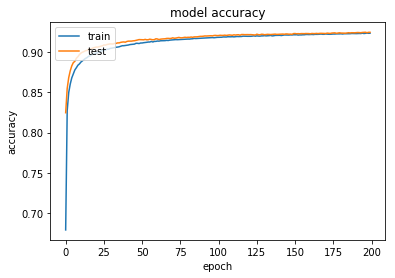

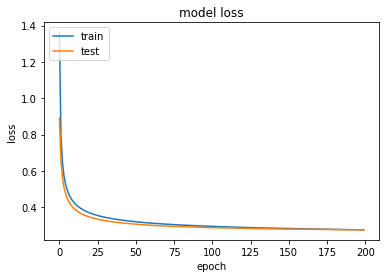

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# <font color='brown'> Improving the simple net in Keras with hidden layers </font>


To improve the last model we can **add additional layers to our network**. So, after the input layer, we have a
first dense layer with the N_HIDDEN neurons and an *activation function ReLu*. This additional layer is
considered hidden because it is not directly connected to either the input or the output. After the first
hidden layer, we have a second hidden layer, again with the N_HIDDEN neurons, followed by an output
layer with 10 neurons, each of which will fire when the relative digit is recognized. The following
code defines this new network. 

So, we have the follow: Input + 2 Hidden Layers + Output (10 neurons)

In [26]:

np.random.seed(1671)  # for reproducibility
# network and training
NB_EPOCH = 20                          #Reducing the epoch from 200 to 20 (10x less)     ******
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10                       # number of outputs = number of digits
OPTIMIZER = SGD()                     # optimizer, explained later in this chapter
N_HIDDEN = 128                        # Nodes to Hidden Layer                            ******
VALIDATION_SPLIT=0.2                  # how much TRAIN is reserved for VALIDATION

# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784

X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize 
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# ONE-HOT ENCONDING
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# M_HIDDEN hidden layers
# 10 outputs
# final stage is softmax

model = Sequential()
# First Hidden Layer
model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
# Second Hidden Layer
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
# Output Layer
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.summary()

#Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])
# Training Model
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
# Test Model
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
#Print results
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_18 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
_________________________________________________________________
activation_19 (Activation)   (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_______________________________

With this two hidden layers we had the next result:
    - Training: 94.56%
    - Validation: 94.97%
    - Test: 94.62%
With this newtwork we have an improvement of 2.2%

## <font color='brown'> Further improving the simple net in Keras with DROPOUT </font>

**Regularization:** randomly drop with the dropout probability some
of the values propagated inside our internal dense network of hidden layers.

In [28]:
from keras.layers.core import Dropout

np.random.seed(1671) # for reproducibility
# network and training
NB_EPOCH = 250
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10                           # number of outputs = number of digits
OPTIMIZER = SGD()                         # optimizer, explained later in this chapter
N_HIDDEN = 128
VALIDATION_SPLIT=0.2                      # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3                             # Dropout                                         *********

# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784

X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# M_HIDDEN hidden layers 10 outputs
model = Sequential()

#First Layer with dropout
model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

#Second Layer with dropout
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

#Output Layer
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE, 
                    epochs=NB_EPOCH,
                    verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

score = model.evaluate(X_test, Y_test, verbose=VERBOSE)

print("Test score:", score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_21 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_22 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1290      
__________

48000/48000 [==============================] - 1s 29us/step - loss: 0.1865 - acc: 0.9453 - val_loss: 0.1282 - val_acc: 0.9615
Epoch 50/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1803 - acc: 0.9461 - val_loss: 0.1267 - val_acc: 0.9622
Epoch 51/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1822 - acc: 0.9466 - val_loss: 0.1254 - val_acc: 0.9636
Epoch 52/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1794 - acc: 0.9459 - val_loss: 0.1244 - val_acc: 0.9632
Epoch 53/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.1752 - acc: 0.9481 - val_loss: 0.1233 - val_acc: 0.9633
Epoch 54/250
48000/48000 [==============================] - 2s 34us/step - loss: 0.1738 - acc: 0.9477 - val_loss: 0.1220 - val_acc: 0.9637
Epoch 55/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1735 - acc: 0.9491 - val_loss: 0.1208 - val_acc: 0.9647
Epoch 56/250
48000/48000 [==============

Epoch 108/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1139 - acc: 0.9666 - val_loss: 0.0933 - val_acc: 0.9724
Epoch 109/250
48000/48000 [==============================] - 1s 30us/step - loss: 0.1146 - acc: 0.9658 - val_loss: 0.0933 - val_acc: 0.9734
Epoch 110/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1140 - acc: 0.9659 - val_loss: 0.0927 - val_acc: 0.9727
Epoch 111/250
48000/48000 [==============================] - 1s 30us/step - loss: 0.1146 - acc: 0.9658 - val_loss: 0.0927 - val_acc: 0.9722
Epoch 112/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.1117 - acc: 0.9661 - val_loss: 0.0917 - val_acc: 0.9737
Epoch 113/250
48000/48000 [==============================] - 1s 30us/step - loss: 0.1127 - acc: 0.9658 - val_loss: 0.0921 - val_acc: 0.9733
Epoch 114/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.1144 - acc: 0.9654 - val_loss: 0.0914 - val_acc: 0.9737
Epoch 115/250
48000/

48000/48000 [==============================] - 1s 30us/step - loss: 0.0862 - acc: 0.9730 - val_loss: 0.0847 - val_acc: 0.9762
Epoch 167/250
48000/48000 [==============================] - 1s 30us/step - loss: 0.0857 - acc: 0.9738 - val_loss: 0.0846 - val_acc: 0.9759
Epoch 168/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.0837 - acc: 0.9747 - val_loss: 0.0842 - val_acc: 0.9759
Epoch 169/250
48000/48000 [==============================] - 2s 36us/step - loss: 0.0853 - acc: 0.9740 - val_loss: 0.0838 - val_acc: 0.9758
Epoch 170/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.0871 - acc: 0.9734 - val_loss: 0.0833 - val_acc: 0.9762
Epoch 171/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.0854 - acc: 0.9738 - val_loss: 0.0831 - val_acc: 0.9766
Epoch 172/250
48000/48000 [==============================] - 1s 30us/step - loss: 0.0845 - acc: 0.9738 - val_loss: 0.0832 - val_acc: 0.9762
Epoch 173/250
48000/48000 [=======

48000/48000 [==============================] - 1s 29us/step - loss: 0.0699 - acc: 0.9791 - val_loss: 0.0804 - val_acc: 0.9772
Epoch 225/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.0673 - acc: 0.9788 - val_loss: 0.0806 - val_acc: 0.9780
Epoch 226/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.0683 - acc: 0.9788 - val_loss: 0.0805 - val_acc: 0.9770
Epoch 227/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.0667 - acc: 0.9792 - val_loss: 0.0807 - val_acc: 0.9772
Epoch 228/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.0693 - acc: 0.9788 - val_loss: 0.0806 - val_acc: 0.9769
Epoch 229/250
48000/48000 [==============================] - 1s 30us/step - loss: 0.0687 - acc: 0.9786 - val_loss: 0.0806 - val_acc: 0.9769
Epoch 230/250
48000/48000 [==============================] - 1s 29us/step - loss: 0.0684 - acc: 0.9787 - val_loss: 0.0801 - val_acc: 0.9768
Epoch 231/250
48000/48000 [=======

With this two hidden layers and dropout we had the next result:
    - Training: 98.08%
    - Validation: 97.75%
    - Test: 97.79%

If we run the same network but only with 20 epoch we will have:
    - Training: 91.54%
    - Validation: 94.48%
    - Test: 94.25%

**Important:** It tell us the 20 epochs is not appropriate to training the model because the Training Accuracy needs to be ABOVE of Test accuracy. Due to that, it was necessary to increase the number of epochs.

It is useful to observe how **accuracy increases** on training and test sets **when the number of epochs
increases**. As you can see in the following graph, these two curves touch at about 250 epochs, and
therefore, there is no need to train further after that point.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


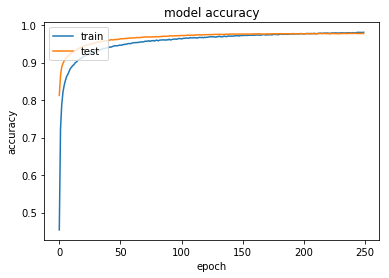

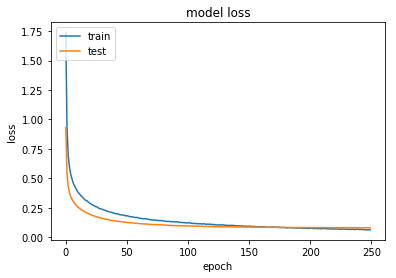

In [29]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Note that it has been frequently observed that networks with random dropout in internal hidden layers
can generalize better on unseen examples contained in test sets. Intuitively, one can think of this as
each neuron becoming more capable because it knows it cannot depend on its neighbors. During
testing, there is no dropout, so we are now using all our highly tuned neurons. In short, it is generally
a good approach to test how a net performs when some dropout function is adopted.